# Bayesian A/B Testing

Welcome to the future of statistics. We're happy you're here.

**Objectives for today (morning):**

- Review Hypothesis Testing
- Compare and Contrast Frequentist vs Bayesian Mindsets
- See what happens when we peek in frequentist testing
- Perform A/B Testing under a Bayesian Framework
- Show why Bayesian A/B Testing is _Bayesian_

### Frequentist

A frequentist subscribes to what is now called "classical statistics". Frequentists define _probability_ as:

```
Probability:
------------
The relative frequency of occurrence of an experiment's outcome as the number of trials
approaches infinity. This is usually referred to as the "long run" frequency of an event.
```

E.i.

$$P(x) = \lim_{n_t \to \infty} \dfrac{n_x}{n_t}$$

where $n_t$ is the number of trials and $n_x$ is the number of trials where the outcome is $x$.

**Most importantly:** Frequentists do hypothesis testing and talk about p-values.

Read more [here](https://en.wikipedia.org/wiki/Probability#Interpretations) and [here](https://en.wikipedia.org/wiki/Frequentist_probability).

### The Bayesian Way

"Probability is just what you _believe_."

IT'S WHAT YOU BELIEVE!

Sound subjective? ... Well, it is! Bayesians agree, to some extent. More on that later.

**The Bayesian way** is to start with a belief, then update your belief as you see evidence. Then update your belief again as you see more evidence. Etc.

For example (using my beliefs):

$$
\begin{align*}
&P(\text{it rained last night}) = 0.15 \\
&P(\text{it rained last night} \, \, | \, \, \text{I am in Seattle}) = 0.8 \\
&P(\text{it rained last night} \, \, | \, \, \text{I am in Seattle and the ground is wet}) = 0.95
\end{align*}
$$

Read more [here](https://en.wikipedia.org/wiki/Probability#Interpretations) and [here](https://en.wikipedia.org/wiki/Bayesian_probability).

### Conclusion: Frequentists vs Bayesian

**Frequentist** care about "long run" probabilities. Everything they do is with this "long run" mindset. E.g. p-values answer the question: "Under the null hypothesis, how often would I'd see this data or something more rare if I sampled from the population over-and-over-and-over... forever."

**Bayesians** care about their "beliefs". Sometimes they are certain about their beliefs, and sometimes their beliefs are vague. Either way, they update their beliefs whenever they see more evidence (i.e. data).

**It's okay to be a little of both.**

# Limitations of Frequentist A/B Tests

- If one page is doing way better than the other, can you scrap the test to not waste time on the first?
- After the experiment is over, do you know how much more likely one page is better than another?
- Your boss decides halfway through your experiment, you should test this other page too... can you update your test?

# Why we can't peek at our results

In [15]:
from __future__ import division
import scipy.stats as scs
def peeking_ab_test(number_of_trials):
    '''
    This function will peek at the results of an A/B test at 100, 200 and 500 trials.
    It the prints the percentage of the time the trial is stopped.
    INPUTS: number_of_trials (int)
    '''
    stopped_trials = 0
    final_trials = 0
    for i in xrange(number_of_trials):
        after_100 = scs.binom.rvs(100, 0.1)
        after_200 = after_100 + scs.binom.rvs(100, 0.1)
        after_500 = after_200 + scs.binom.rvs(300, 0.1)
        if scs.binom_test(after_500, 500, 0.1, alternative='greater') <= 0.05:
            final_trials += 1
        if (scs.binom_test(after_100, 100, 0.1, alternative='greater') <= 0.05) or (scs.binom_test(after_200, 200, 0.1, alternative='greater') <= 0.05) or (scs.binom_test(after_500, 500, 0.1, alternative='greater') <= 0.05):
            stopped_trials += 1
    print "The true number of trials with a p-value <= 0.05 are {}%\nThe trials that were found to be stopped early are {}%".format(final_trials/number_of_trials*100, stopped_trials/number_of_trials*100)

In [16]:
peeking_ab_test(10000)

The true number of trials with a p-value <= 0.05 are 4.43%
The trials that were found to be stopped early are 9.2%


## Let's do Bayesian A/B Testing

So, we know how to run hypothesis tests (from the frequentist world), and we can do A/B testing via hypothesis testing, of course.

But now let's do A/B testing under a Bayesian framework.

First, we need to learn about a new distribution, the **Beta Distribution**.

### The Beta Distribution: $\text{Beta}(\alpha, \beta)$

The beta distribution has two hyper-parameters (also known as "shape parameters"):
- $\alpha > 0$: we will use this to encode the number of "successes" of a website (more on that later)
- $\beta > 0$: we will use this to encode the number of "failures" of a website (more on that later)

Support: $x \in [0, 1]$

PDF: $f(x) = \dfrac{x^{\alpha - 1} (1-x)^{\beta - 1}}{B(\alpha, \beta)}$

where $B(\alpha, \beta) = \dfrac{\Gamma(\alpha)\Gamma(\beta)}{\Gamma(\alpha + \beta)}$

where $\Gamma(x)$ is an extension of the factorial function which works for a wider range of input (like any positive real value, which is why it works here).

**Get a feel for the Beta Distribution:**

Let's plot a few Beta Distributions (with varying shape parameters). Notice the support of each distribution is $x \in [0, 1]$.

In [3]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.reload_library()
#plt.style.use('galvanize')

def plot_beta(alpha, beta, ax, title=None, label=None, xticks=[0.0, 0.5, 1.0]):

    # Build a beta distribtuion scipy object.
    dist = scs.beta(alpha, beta)

    # The support (always this for the beta dist).
    x = np.linspace(0.0, 1.0, 201)

    # The probability density at each sample support value.
    y = dist.pdf(x)

    # Plot it all.
    lines = ax.plot(x, y, label=label)
    ax.fill_between(x, y, alpha=0.2, color=lines[0].get_c())
    if title: ax.set_title(title)
    ax.get_yaxis().set_ticks([])
    #ax.get_yaxis().set_ticks([np.max(y)])
    ax.get_xaxis().set_ticks(xticks)
    ax.set_ylim(0.0, np.max(y)*1.2)

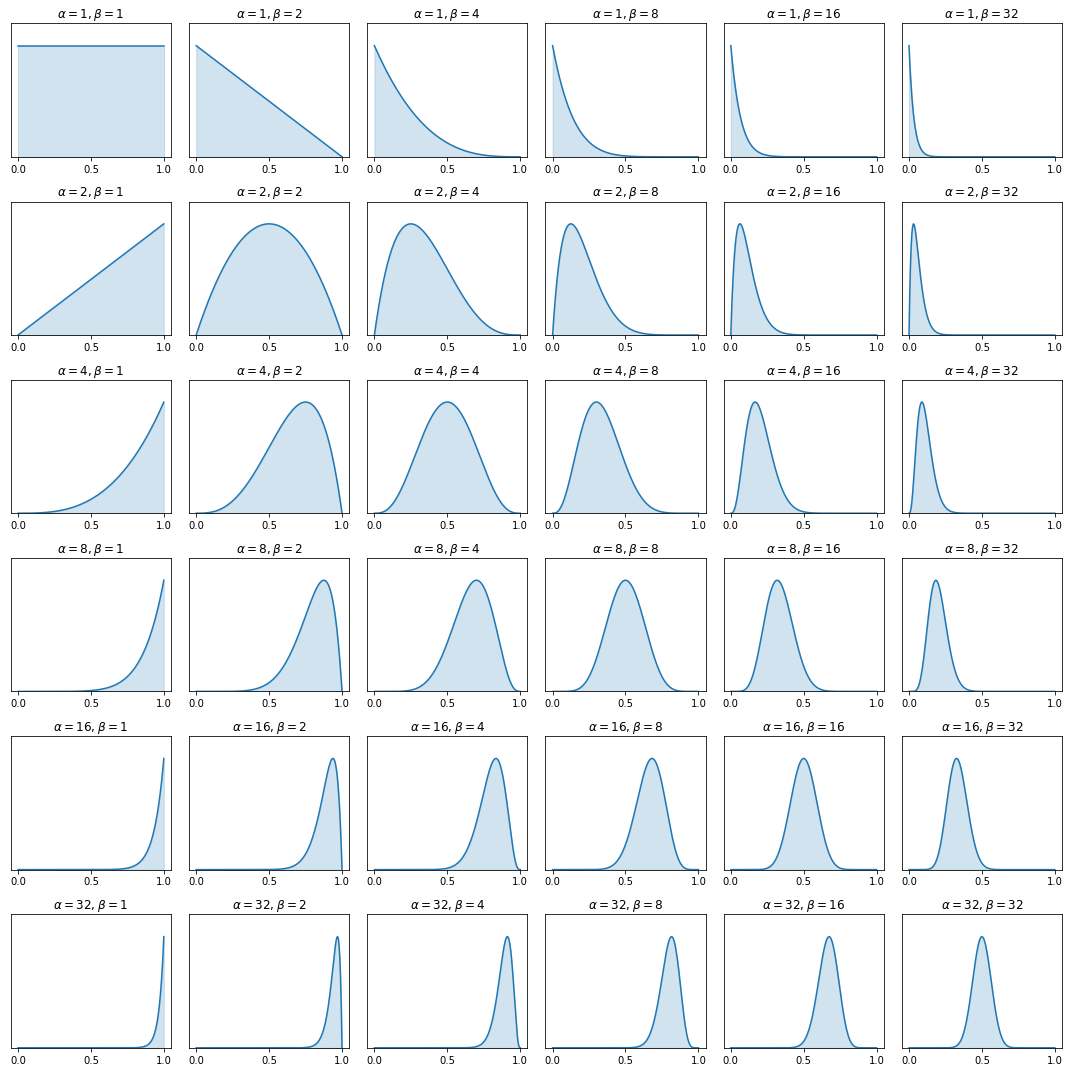

In [4]:
import numpy as np
import scipy.stats as scs

# The shape parameters.
alpha_values = [1, 2, 4, 8, 16, 32]
beta_values  = [1, 2, 4, 8, 16, 32]
n_rows, n_cols = len(alpha_values), len(beta_values)
alpha_beta_pairs = ( (i, j) for i in alpha_values for j in beta_values )

# Create a large figure.
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 15))

# Plot each beta dist. One plot per pair of shape params.
for (alpha, beta), ax in zip(alpha_beta_pairs, axes.flatten()):
    plot_beta(alpha, beta, ax, r"$\alpha={} ,  \beta={}$".format(alpha, beta))

plt.tight_layout()

**What patterns do you see in the above distributions?**

Here's a few:
 - If $\alpha$ is larger than $\beta$, the distribution leans to the **right**.
 - If $\alpha$ is smaller than $\beta$, the distribution leans to the **left**.
 - If $\alpha = \beta$, the distribution is **symmetric** and **centered** at $0.5$.
 - The distribution gets **skinnier** as $\alpha$ and $\beta$ increase.

To be more precise:

The **mean** of the Beta Distribution is: $E(X) = \dfrac{\alpha}{\alpha + \beta}$

The **variance** of the Beta Distribution is: $\text{Var}(X) = \dfrac{\alpha \beta}{(\alpha + \beta)^2 (\alpha + \beta + 1)}$

### How we can use the Beta Distribution (A BIG IDEA)

What if we set:
- $\alpha = 1 + \text{number of conversions on our website}$
- $\beta = 1 + \text{number of misses on our website}$

Then, as we know, the **mean of the beta distribution** would be $\dfrac{\alpha}{\alpha + \beta}$ which equals smoothed **conversion rate**! That's convenient.

Also, the more visitors we have (i.e. the larger $(\alpha + \beta)$), then the **smaller the variance of our beta distribution will be**. That's also convenient.

Also, don't forget that the support of the beta distribution is $x \in [0, 1]$ which is the same range for conversion rates (0% up to 100%).

Put all this together, we can use the beta distribution to model the probability of the conversion rate of our website. This makes sense. Recall: We are trying to figure out what our conversion rate is. The beta distribution is one way to model our **belief** of what the conversion rate might be.

Take a moment for this to sink in. It's rather weird. A continuous probability distribution (like the beta distribution) puts relative likelihoods to each of the values in the support. In our case, the support is theorized conversion rates. Let that sink in. On the y-axis of the PDF we have probability density, and on the x-axis of the PDF we have probabilities (conversion rates). So we have probabilities of probabilities. Yikes. But it's okay. We like it.

**Why we like it:** The reason we like it is that this lets us know the **strength of our belief** about the conversion rate of our website. Check out the three plots below:

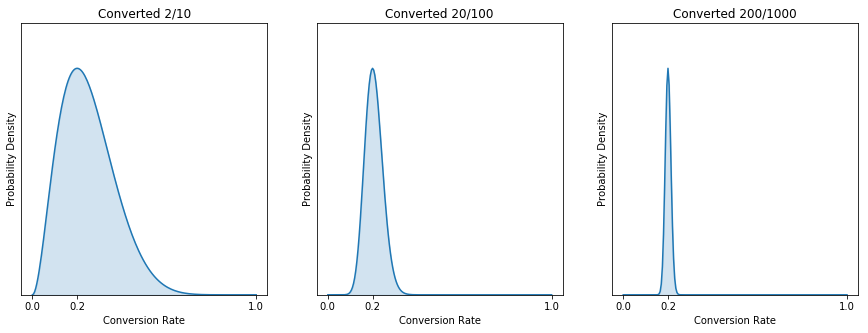

In [5]:
def get_beta_dist_params(website_samples):
    website_samples = np.array(website_samples)
    num_conversions = website_samples.sum()
    total_visitors = len(website_samples)
    alpha = num_conversions + 1
    beta = (total_visitors - num_conversions) + 1
    mean = 1. * num_conversions / total_visitors
    return alpha, beta, mean, num_conversions, total_visitors

def plot_beta_website(website_samples, ax, label=None):
    alpha, beta, mean, num_conversions, total_visitors = get_beta_dist_params(website_samples)
    title = None if label else r"Converted {}/{}".format(num_conversions, total_visitors)
    plot_beta(alpha, beta, ax, title, label, [0.0, mean, 1.0])
    ax.set_xlabel("Conversion Rate")
    ax.set_ylabel("Probability Density")

fig, (left, mid, right) = plt.subplots(1, 3, figsize=(15, 5))

plot_beta_website([0, 1, 0, 0, 0]*2, left)
plot_beta_website([0, 1, 0, 0, 0]*20, mid)
plot_beta_website([0, 1, 0, 0, 0]*200, right)

It is clear that we can use this distribution to model both (1) our belief of the conversion rate based on the data we have (i.e. via the mean), and (2) the strength of our belief (i.e. via the variance).

**A good Bayesian never claims to know anything exactly. Instead they have some beliefs, and they have various levels of strengths regarding their beliefs.**

This is super cool.

### But aren't we supposed to be talking about A/B testing?

YES! We're finally ready to do the Bayesian A/B testing.

Say we have two versions of our website: version A and version B.

Let's read in the log of our historical visitors for both version A and version B.

In [6]:
x = np.load("samples.npz")

site_A_samples = x['site_A_samples'][:1000]
site_B_samples = x['site_B_samples'][:1000]

np.mean(site_A_samples), np.mean(site_B_samples)

(0.20200000000000001, 0.22500000000000001)

Now let's plot our belief about each site's conversion rate.

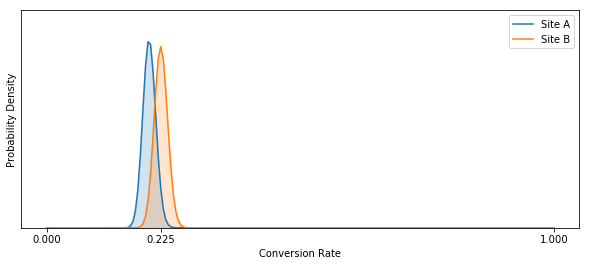

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))

plot_beta_website(site_A_samples, ax, label="Site A")
plot_beta_website(site_B_samples, ax, label="Site B")
ax.legend()

### Important question: What's the probability that site B is better than site A?

Thoughts?

It would be cool if we could figure out how much of site B's Beta Dist was to the right of site A's. But we can't do that algebraically. But we can estimate it through simulation! And the code is short and easy:

In [8]:
num_simulations = 100000

alpha, beta = get_beta_dist_params(site_A_samples)[:2]
dist_A = scs.beta(alpha, beta)

alpha, beta = get_beta_dist_params(site_B_samples)[:2]
dist_B = scs.beta(alpha, beta)

simulated_A = dist_A.rvs(num_simulations)
simulated_B = dist_B.rvs(num_simulations)

print (simulated_B > simulated_A).mean()

0.89704


Translation: In our simulation, 89% of the time site B is better than site A. We can then interpret this as a probability, meaning we can say:

> "It is 89% likely that site B is better than site A."

**CAN FREQUENTIST DO THAT?** No, they can NOT!

### What's the 95% credible interval of site B's conversion rate?

We'd like to do something analogous to a "confidence interval", but we'll call it a "credible interval" under our new A/B testing framework. To compute the 95% credible interval, we'll chop off 2.5% from each tail of site B's distribution and see what the bounds are. That gives us an interval which contains the true conversion rate with 95% probability. Yay! That's what we've always wanted.

In [9]:
interval_size = 0.95
tail_area = (1 - interval_size) / 2

print dist_B.ppf(tail_area), dist_B.ppf(1 - tail_area)

0.200211915617 0.251923532987


### What if the difference between sites A and B is larger?

Let's explore this.

In [10]:
x = np.load("samples.npz")

site_A_samples = x['site_A_samples'][:1000]
site_B_samples = x['site_C_samples'][:1000]

np.mean(site_A_samples), np.mean(site_B_samples)

(0.20200000000000001, 0.315)

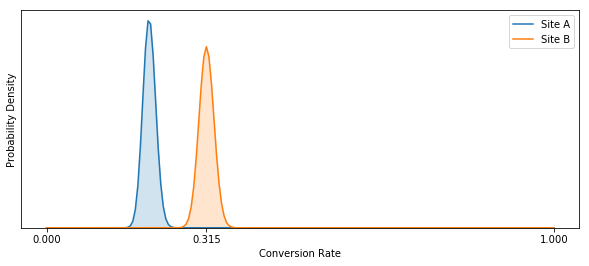

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))

plot_beta_website(site_A_samples, ax, label="Site A")
plot_beta_website(site_B_samples, ax, label="Site B")
ax.legend()

In [12]:
alpha, beta = get_beta_dist_params(site_A_samples)[:2]
dist_A = scs.beta(alpha, beta)

alpha, beta = get_beta_dist_params(site_B_samples)[:2]
dist_B = scs.beta(alpha, beta)

simulated_A = dist_A.rvs(num_simulations)
simulated_B = dist_B.rvs(num_simulations)

print (simulated_B > simulated_A).mean()

1.0


In our simulation, 100% of the time site B is better than site A. We can then interpret this as a probability, meaning we can say:

> "It is 100% likely that site B is better than site A."

We used 1,000 samples of each site just now. We _probably_ didn't need this much data in this case; we probably spent longer running this test than needed. Re-run the three cells above using less data. (You really only need about 300 samples of each site with this amount of difference between the sites.)

### Benefits of Bayesian A/B Testing

In general, Bayesian A/B testing is better for these reason:

1. You can say stuff like "It is \_\_% likely that site \_\_ is better than site \_\_."
2. You can stop the test early based on surprising data.
3. You can update the test while it's running.

## Why do we call this Bayesian A/B Testing?

I haven't yet proved to you that what we did above is actually _correct_. All I've done is show that the Beta Distribution _seems_ to do what we want if we set $\alpha$ and $\beta$ to the number of conversions and failures, respectively. Let's work on showing _why_ this works.

We can derive it by beginning with Bayes' Theorem. We've used Bayes' Theorem before for little things, like everyone favorite problem: The Cookie Problem. We're about to do something **way different** using Bayes' Theorem though. First, let's just recall the theorem:

![](images/bayes_formula.png)

$\theta$ represents the random variable that is our unknown conversion rate, and $y$ is the number of conversions we've observed on the website to-date.

Next, we note that the denominator on the right ($P(y)$) is just a normalizing term and we don't care about it at all. So, we'll simplify it to:

$$P(\theta \, | \, y) \propto P(y \, | \, \theta) P(\theta)$$

In the past we've only put scalar values into each part of the equation above, but... what if we plugged PDF equations into each part? Let's try it.

Our prior ($P(\theta)$) will be a uniform distribution, meaning we don't have any initial belief about what values $\theta$ should be -- we see all values as equally likely (we don't _have_ to do it this way, but this will work fine).

Our likelihood distribution ($P(y \, | \, \theta)$) is a Binomial distribution. It will tell us the likelihood of our data under various values of $\theta$. 

Finally, the posterior distribution ($P(\theta \, | \, y)$) tells us what we actually want to know: the relative probability of each value of $\theta$ (i.e. the relative probability of each possible conversion rate).

$$
\begin{align*}
P(\theta \, | \, y) &\propto P(y \, | \, \theta) * P(\theta) \\
P(\theta \, | \, y) &\propto \text{Binomial}(n, \theta) * \text{Beta}(\alpha, \beta) \\
P(\theta \, | \, y) &\propto {n \choose y} \theta^y (1-\theta)^{n-y} * \dfrac{\theta^{\alpha - 1} (1-\theta)^{\beta - 1}}{B(\alpha, \beta)} \\
P(\theta \, | \, y) &\propto \theta^y (1-\theta)^{n-y} * \theta^{\alpha - 1} (1-\theta)^{\beta - 1} \\
P(\theta \, | \, y) &\propto \theta^{\alpha + y - 1} (1-\theta)^{\beta + n - y - 1} \\
P(\theta \, | \, y) &= \text{Beta}(\alpha' = \alpha + y, \, \, \beta' = \beta + n - y) \\
\end{align*}
$$

All that's to say, if you multiply a Beta distribution by a Binomial distribution, out pops a Beta distribution:

$$\text{Beta} \propto \text{Binomial} * \text{Beta}$$

This relationship, where your prior and posterior are of the same distribution family, is called a "conjugate prior".

All that math above is just to show that our process for modeling conversion rates on websites is sound. What's really going on is that we've found a short-cut way of applying Bayes' theorem to update our prior beliefs. We usually make our first prior just a uniform distribution by using a Beta distribution with $\alpha=1$ and $\beta=1$.

To recap, we model the conversion rate as a Beta distribution where:
- $\alpha = 1 + \text{number of conversions on our website}$
- $\beta = 1 + \text{number of misses on our website}$

This final plot shows how we can update our belief with more-and-more data to get stronger-and-stronger beliefs of the underlying conversion rate of our website.

In [13]:
x = np.load("samples.npz")

site_A_samples = x['site_A_samples']

len(site_A_samples), np.mean(site_A_samples)

(10000, 0.20549999999999999)

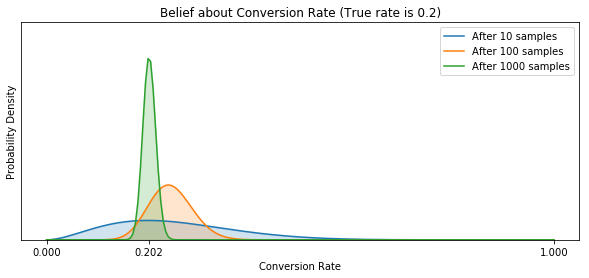

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))

num_samples = [10, 100, 1000]   # , 10000

for k in num_samples:
    samples = site_A_samples[:k]
    plot_beta_website(samples, ax, label="After {} samples".format(k))

ax.set_title("Belief about Conversion Rate (True rate is 0.2)")
ax.legend()

## Final Words

We should still respect _frequentists_ even if their methods are a little silly. The silliness of frequentist methods is entirely due to the fact that those methods were created before modern computers. Those methods lean on limits and integrals which can be done by hand. It's from those limits and integrals that they have to take the "long run" point of view.

Bayesians still build on top of the laws of probability and the well-known distributions, but Bayesians take a different approach to how they interpret probability, which fits better with our needs (usually). Bayesians love to build layers of distributions one atop the other, using Bayes' theorem to string them all together. Once built, they  visualize the final distribution by repeated sampling, requiring a lot of computation (thank you, computers).

All scientists love data. We love data because it helps us understand the world. That's why we like the Bayesian mindset. We believe things, we collect data, and we refine our beliefs. Then we repeat that. I leave you with this final _xkcd_.

<img src="https://imgs.xkcd.com/comics/the_difference.png" width=500px>

# Discuss Burn-in

- Adoption of software
- Should we add a new button?